In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import datetime as dt
import math
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

In [3]:
# tickers for companies
stockCodes = ['SASA.IS']

# start and end dates for financial data (last ~5 years)
startDate = dt.datetime(2017, 11, 20)
endDate = dt.datetime(2022, 11, 24)

# split ratio for training and testing datasets
splitRatio = 0.8

# number of past days the model will take into account while training
n_pasts = [60]

# number of experiments
n_run = 1

# number of epochs with no improvement after which training will be stopped (for early stopping)
n_patience = 8

# batch size for training
batchSize = 16

# number of epoch for training
n_epoch = 50

# list of results
res = []



DATA PREPROCESSING
Stock Code: SASA.IS
[*********************100%***********************]  1 of 1 completed
Shape of data: (1277, 6)
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-11-20    1.080971    1.082812    1.012834    1.029408    0.990806   
2017-11-21    1.007310    1.101227    0.981529    1.084654    1.043981   
2017-11-22    1.178571    1.300111    1.178571    1.300111    1.251359   
2017-11-23    1.351674    1.436384    1.307477    1.307477    1.258448   
2017-11-24    1.289062    1.290904    1.211718    1.252232    1.205275   
...                ...         ...         ...         ...         ...   
2022-11-17  187.300003  189.100006  167.699997  167.699997  167.699997   
2022-11-18  151.000000  151.000000  151.000000  151.000000  151.000000   
2022-11-21  135.899994  135.899994  135.899994  135.899994  135.899994   
2022-11-22  123.099998  149.399994  123.000000  149

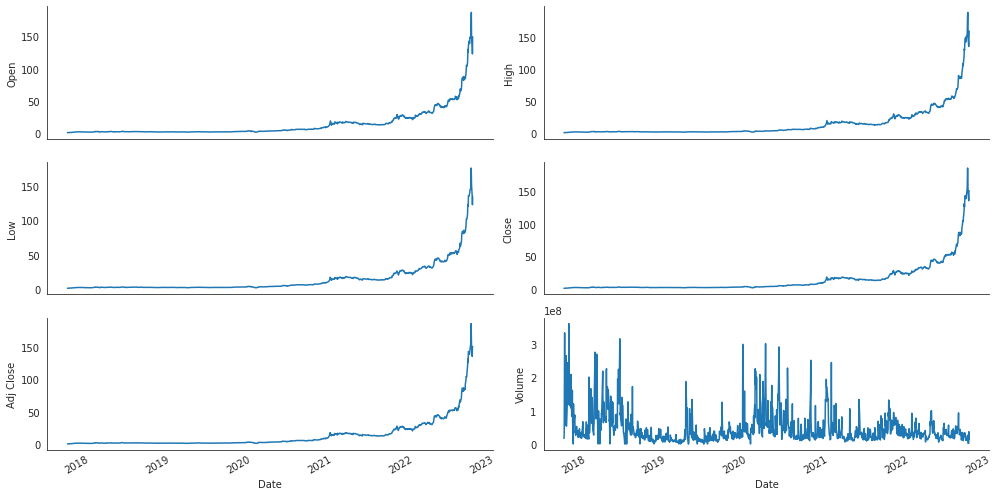

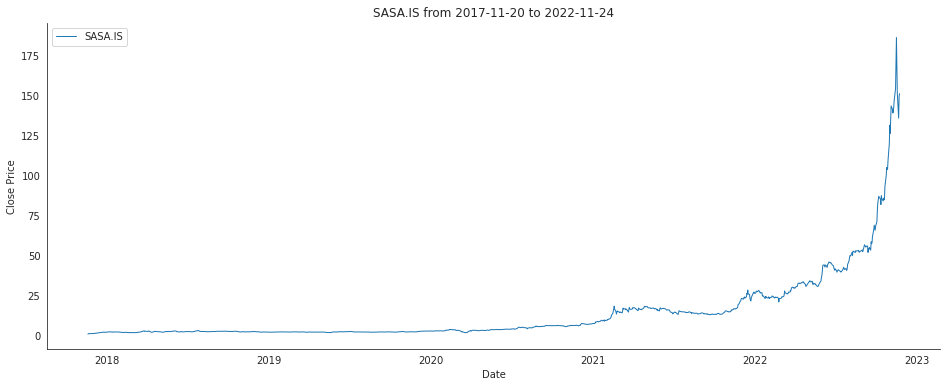

Shape of data_featured: (1277, 1)
                 Close
Date                  
2017-11-20    1.029408
2017-11-21    1.084654
2017-11-22    1.300111
2017-11-23    1.307477
2017-11-24    1.252232
...                ...
2022-11-17  167.699997
2022-11-18  151.000000
2022-11-21  135.899994
2022-11-22  149.399994
2022-11-23  151.199997

[1277 rows x 1 columns]

Number of samples in training dataset is determined as to be 1021.
Shape of dataTraining: (1021, 1).
Shape of dataTesting: (256, 1).
Shape of dataTrainingScaled: (1021, 1)
First a few training samples:
[[0.        ]
 [0.00317082]
 [0.01553686]
 [0.01595963]
 [0.01278887]]


Stock Code: SASA.IS  Past Days: 60
First three samples for input part:
[array([[0.        ],
       [0.00317082],
       [0.01553686],
       [0.01595963],
       [0.01278887],
       [0.01215472],
       [0.00856113],
       [0.01278887],
       [0.01627673],
       [0.01564258],
       [0.01860196],
       [0.02430938],
       [0.02177277],
       [0.02399233],


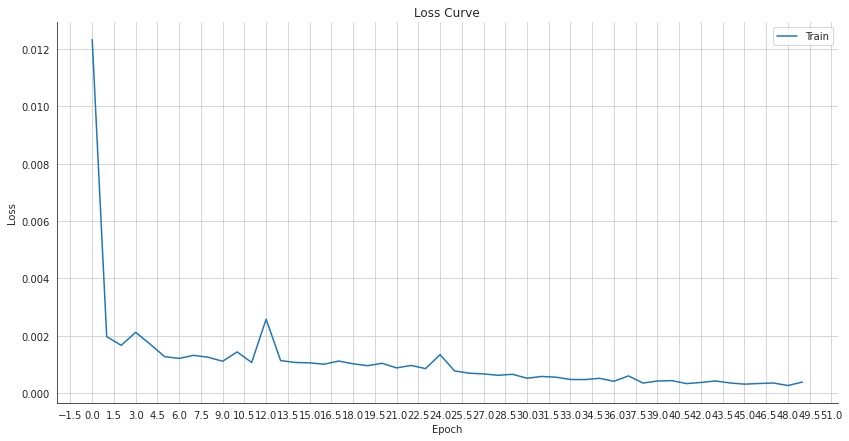



TESTING
Shape of dataTestingScaled: (316, 1)
First a few testing samples:
[[0.00363552]
 [0.00248139]
 [0.00328928]
 [0.00421259]
 [0.00582838]]
[[[0.00363552]
  [0.00248139]
  [0.00328928]
  [0.00421259]
  [0.00582838]
  [0.00629003]
  [0.0068671 ]
  [0.00623233]
  [0.00432801]
  [0.00328928]
  [0.00450112]
  [0.00352011]
  [0.00352011]
  [0.00334699]
  [0.00178891]
  [0.00334699]
  [0.00219286]
  [0.00080789]
  [0.        ]
  [0.00075019]
  [0.00161579]
  [0.00098101]
  [0.00300075]
  [0.00144267]
  [0.00155808]
  [0.00190432]
  [0.00213515]
  [0.00213515]
  [0.00132725]
  [0.00138496]
  [0.00201973]
  [0.0042703 ]
  [0.0051359 ]
  [0.00450112]
  [0.00305846]
  [0.00225056]
  [0.0016735 ]
  [0.00230827]
  [0.00271221]
  [0.0034047 ]
  [0.00455883]
  [0.00646315]
  [0.00969473]
  [0.01327255]
  [0.01413815]
  [0.01448439]
  [0.01154135]
  [0.01177217]
  [0.01044492]
  [0.0111374 ]
  [0.01015639]
  [0.01292631]
  [0.01777367]
  [0.01679266]
  [0.01777367]
  [0.0180622 ]
  [0.0223325 

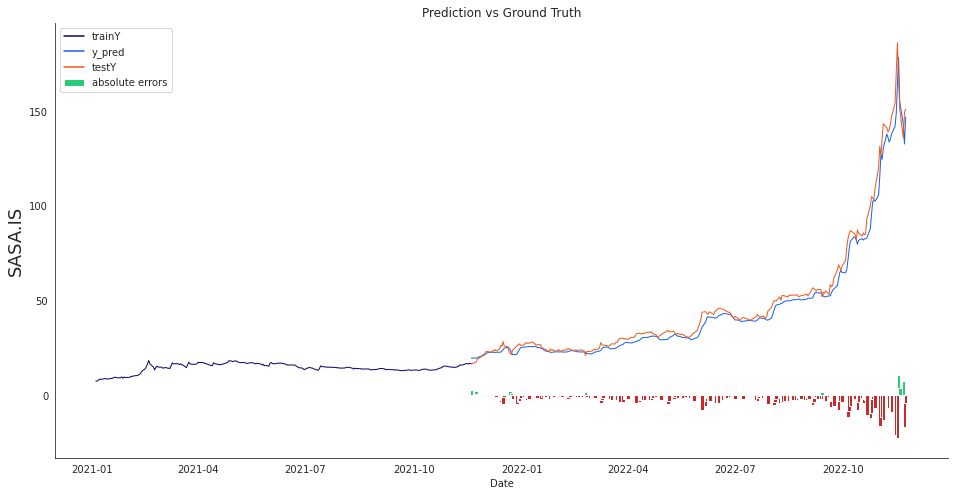

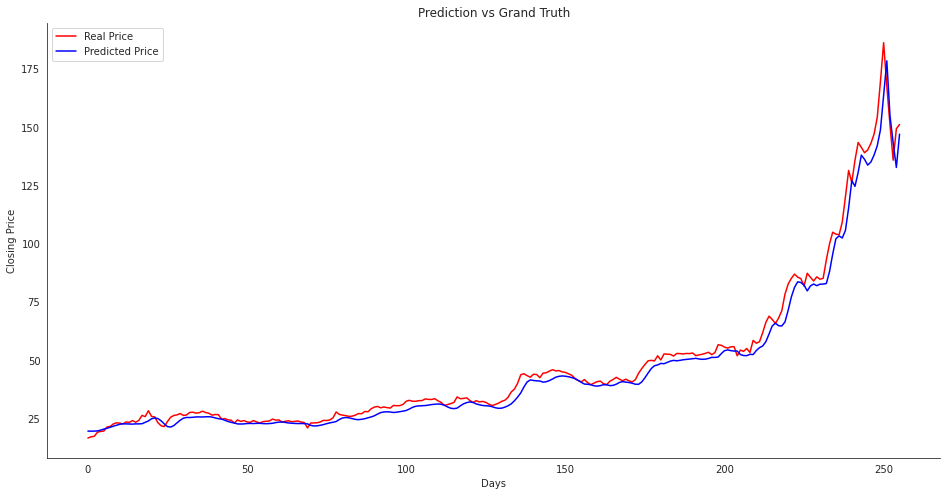

In [4]:
# loop for trying different stock codes
for i in range(len(stockCodes)):
    print('\n\n\033[31;1;4mDATA PREPROCESSING\033[0m')
    print('\x1b[31mStock Code: {}\x1b[0m'.format(stockCodes[i]))
    
    #################### DATA COLLECTION ####################
    # getting financial data between start and end dates from Yahoo Finance using yfinance API
    data = yf.download(stockCodes[i], start = startDate, end = endDate)

    # 2020-07-24 removing 2 decimal digits in BIST100
    if stockCodes[i] == 'XU100.IS':
        data2 = data.loc[:'2020-07-24']
        data3 = data2[['Open', 'High', 'Low', 'Close', 'Adj Close']] / 100
        data3['Volume'] = data2['Volume']
        data4 = data3.append(data.loc['2020-07-25':])
        del data
        data = data4.copy()

    # columns: High, Low, Open, Close, Volume, Adj Close
    print('Shape of data: {}'.format(data.shape))

    # let's check it
    print(data)

    # plotting line charts for all features
    df_plot = data.copy()
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, figsize = (14, 7))
    for id, ax in enumerate(fig.axes):
        sb.lineplot(data = df_plot.iloc[:, id], ax = ax)
        ax.tick_params(axis = 'x', rotation = 30, labelsize = 10, length = 0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

    # plotting line chart for 'Close'
    years = mdates.YearLocator() 
    fig, ax1 = plt.subplots(figsize = (16, 6))
    ax1.xaxis.set_major_locator(years)
    ax1.legend([stockCodes[i]], fontsize = 12)
    plt.title(stockCodes[i] + ' from ' + str(startDate.date()) + ' to ' + str(endDate.date()))
    sb.lineplot(data = data['Close'], label = stockCodes[i], linewidth = 1.0)
    plt.ylabel('Close Price')
    plt.show()
    #########################################################

    #################### DATA PREPROCESSING (DATA CLEANING & FEATURE ENGINEERING) ####################
    # feature selection (the first row is removed because of fair sample usage)
    data_featured = data[['Close']].copy()

    # columns: Close
    print('Shape of data_featured: {}'.format(data_featured.shape))

    # let's check it
    print(data_featured)
    ##################################################################################################
    
    #################### DATA PREPROCESSING (SPLITTING DATA FOR TRAINING & TESTING) ####################
    # determining the number of samples in training dataset
    n_trainSamples = math.floor(data_featured.shape[0] * splitRatio)
    
    # let's check the number of training samples
    print('\nNumber of samples in training dataset is determined as to be {}.'.format(n_trainSamples))

    # creating training dataset
    dataTraining = data_featured[data_featured.index < data_featured.index[n_trainSamples]].copy()
    print('Shape of dataTraining: {}.'.format(dataTraining.shape))

    # creating testing dataset
    dataTesting = data_featured[data_featured.index >= data_featured.index[n_trainSamples]].copy()
    print('Shape of dataTesting: {}.'.format(dataTesting.shape))
    ####################################################################################################

    #################### DATA PREPROCESSING (SCALING / STANDARDIZATION FOR TRAINING DATA) ####################
    # scaler definition for scaling 'Close' feature to a range between 0 and 1
    minmax_scaler = MinMaxScaler(feature_range = (0, 1))
    
    # applying min-max scaling
    dataTrainingScaled = minmax_scaler.fit_transform(np.array(dataTraining))

    # let's check it
    print('Shape of dataTrainingScaled: {}'.format(dataTrainingScaled.shape))
    print('First a few training samples:')
    print(dataTrainingScaled[:5])
    ##########################################################################################################

    # loop for trying different number of past days
    for p in range(len(n_pasts)):
        print('\n\n\x1b[31mStock Code: {} \x1b[0;36m Past Days: {}\x1b[0m'.format(stockCodes[i], n_pasts[p]))

        #################### DATA PREPROCESSING (TRANSFORMING TRAINING DATA - APPLYING SLIDING WINDOW) ####################
        # input and output lists for training dataset
        trainX = []
        trainY = []

        # creating input and output lists for training dataset using sliding window technique
        for l in range(n_pasts[p], dataTrainingScaled.shape[0]):
            trainX.append(dataTrainingScaled[l - n_pasts[p]: l])
            trainY.append(dataTrainingScaled[l, 0])
        
        # let's check the first three input samples
        print('First three samples for input part:')
        print(trainX[:3])
        # let's check the first three output samples
        print('First three samples for output part:')
        print(trainY[:3])

        # converting input and output lists to numpy array
        trainX, trainY = np.array(trainX), np.array(trainY)

        # let's check the shape of input and output arrays
        print('Input Shape (Training): {}'.format(trainX.shape))
        print('Output Shape (Training): {}'.format(trainY.shape))
        ###################################################################################################################

        # loop for experiments
        for r in range(n_run):
            print('\n\n\033[31;1;4mTRAINING\033[0m')
            print('\x1b[31mStock Code: {} \x1b[0;36m Past Days: {} \x1b[1;35m Run: {}\x1b[0m'.format(stockCodes[i], n_pasts[p], r + 1))

            #################### MODEL BUILDING ####################
            # determining number of units for LSTM model
            n_neurons = trainX.shape[1] * trainX.shape[2]

            print('Number of neurons: {}'.format(n_neurons))

            # creating a stacked LSTM model (relu or not ???, dropouts or not ???)
            model = Sequential()
            
            model.add(LSTM(units = n_neurons, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
            #model.add(Dropout(0.1))
            model.add(LSTM(units = n_neurons, return_sequences = True))
            #model.add(Dropout(0.1))
            model.add(LSTM(units = n_neurons, return_sequences = False))
            model.add(Dense(30, activation = 'relu'))
            model.add(Dense(1))

            model.summary()

            # compiling the model (farklı learning rate'ler denenmedi ???)
            model.compile(optimizer = 'adam', loss = 'mean_squared_error')

            # early stopping condition for training
            early_stop = EarlyStopping(monitor = 'loss', patience = n_patience, verbose = 1)
            ########################################################

            #################### TRAINING ####################
            # training
            history = model.fit(trainX, trainY, batch_size = batchSize, epochs = n_epoch, callbacks = [early_stop], verbose = 1)

            # plotting loss curve
            fig, ax = plt.subplots(figsize = (14, 7), sharex = True)
            sb.lineplot(data = history.history['loss'])
            plt.title('Loss Curve')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            ax.xaxis.set_major_locator(plt.MaxNLocator(n_epoch))
            plt.legend(['Train', 'Test'], loc = 'upper right')
            plt.grid()
            plt.show()
            ##################################################

            #################### TESTING ####################
            #################### DATA PREPROCESSING (SCALING / STANDARDIZATION FOR TESTING DATA) ####################
            # getting last 60 training samples
            pastTrainingData = dataTraining.tail(n_pasts[p])
            
            # appending pastTrainingData to dataTesting 
            dataTest = pastTrainingData.append(dataTesting, ignore_index = True)

            # applying min-max scaling
            dataTestingScaled = minmax_scaler.fit_transform(np.array(dataTest))

            # let's check it
            print('\n\n\033[31;1;4mTESTING\033[0m')
            print('Shape of dataTestingScaled: {}'.format(dataTestingScaled.shape))
            print('First a few testing samples:')
            print(dataTestingScaled[:5])
            ##########################################################################################################

            #################### DATA PREPROCESSING (TRANSFORMING TESTING DATA - APPLYING SLIDING WINDOW) ####################
            # input and output lists for testing dataset
            testX = []
            testY = []

            # creating input and output lists for training dataset using sliding window technique
            for h in range(n_pasts[p], dataTestingScaled.shape[0]):
                testX.append(dataTestingScaled[h - n_pasts[p]:h])
                testY.append(dataTestingScaled[h, 0])

            # converting input and output lists to numpy array
            testX, testY = np.array(testX), np.array(testY)

            # let's check the first three input samples
            print(testX[:3])
            # let's check the first three output samples
            print(testY[:3])

            # let's check the shape of input and output arrays
            print('Input Shape (Test): {}'.format(testX.shape))
            print('Output Shape (Test): {}'.format(testY.shape))
            ###################################################################################################################

            #################### PREDICTIONS ####################
            # getting predicted values
            print('\n\n\033[31;1;4mPREDICTION\033[0m')
            y_pred_scaled = model.predict(testX)
            y_pred = minmax_scaler.inverse_transform(y_pred_scaled)
            y_test_unscaled = minmax_scaler.inverse_transform(testY.reshape(-1, 1))
            #####################################################

            #################### EVALUATION ####################
            print('\n\n\033[31;1;4mRESULTS\033[0m')

            # Directional Accuracy (DA) (Schmidhuber J., Deep learning in neural networks: an overview, 2015, Neural Netw 61:85–117)
            da_test = np.zeros(len(y_test_unscaled) - 1)
            da_pred = np.zeros(len(y_pred) - 1)

            for a in range(len(y_test_unscaled) - 1):
                if y_test_unscaled[a] < y_test_unscaled[a + 1]:
                    da_test[a] = 1
                
                if y_pred[a] < y_pred[a + 1]:
                    da_pred[a] = 1
            
            cnt = 0
            for b in range(len(y_test_unscaled) - 1):
                if da_pred[b] == da_test[b]:
                    cnt += 1
            
            DA = cnt / len(da_pred) * 100
            print(f'Direct Accuracy (DA): {np.round(DA, 2)}')

            # Mean Absolute Error (MAE)
            MAE = mean_absolute_error(y_test_unscaled, y_pred)
            print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

            # Root Mean Squared Error (RMSE)
            RMSE = mean_squared_error(y_test_unscaled, y_pred)
            print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)}')

            # Mean Absolute Percentage Error (MAPE)
            MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
            print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

            # Median Absolute Percentage Error (MDAPE)
            #MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
            #print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

            # keeping track of results
            resDict = {'stock': stockCodes[i], 'past': n_pasts[p], 'run': (r + 1), 'da': DA, 'mae': MAE, 'rmse': RMSE, 'mape': MAPE}
            res.append(resDict)
            ####################################################

            #################### VISUALIZATION ####################
            # the date from which on the date is displayed
            display_start_date = "2021-01-01"

            # adding the difference between the valid and predicted prices
            train = pd.DataFrame(data_featured[:n_trainSamples + 1]).rename(columns = {'Close': 'trainY'})
            valid = pd.DataFrame(data_featured[n_trainSamples:]).rename(columns = {'Close': 'testY'})
            valid.insert(1, 'y_pred', y_pred, True)
            valid.insert(1, 'residuals', valid['y_pred'] - valid['testY'], True)
            df_union = pd.concat([train, valid])

            # zooming in to a closer timeframe
            df_union_zoom = df_union[df_union.index > display_start_date]

            # creating line chart
            fig, ax1 = plt.subplots(figsize = (16, 8), sharex = True)
            plt.title('Prediction vs Ground Truth')
            sb.set_palette(['#090364', '#1960EF', '#EF5919'])
            plt.ylabel(stockCodes[i], fontsize = 18)
            sb.lineplot(data = df_union_zoom[['trainY', 'y_pred', 'testY']], linewidth = 1.0, dashes = False, ax = ax1)

            # creating bar chart for absolute errors
            df_sub = ['#2BC97A' if x > 0 else '#C92B2B' for x in df_union_zoom['residuals'].dropna()]
            ax1.bar(height = df_union_zoom['residuals'].dropna(), x = df_union_zoom['residuals'].dropna().index, width = 3, label = 'absolute errors', color = df_sub)
            plt.legend()
            plt.show()

            # visualising results
            plt.figure(figsize = (16, 8))
            plt.plot(y_test_unscaled, color = 'red', label = 'Real Price')
            plt.plot(y_pred, color = 'blue', label = 'Predicted Price')
            plt.title('Prediction vs Grand Truth')
            plt.xlabel('Days')
            plt.ylabel('Closing Price')
            plt.legend()
            plt.show()
            #######################################################
            #################################################

In [5]:
res

[{'stock': 'SASA.IS',
  'past': 60,
  'run': 1,
  'da': 51.37254901960784,
  'mae': 2.914774917066097,
  'rmse': 18.953708033482833,
  'mape': 6.002482720758307}]

In [6]:
df_res = pd.DataFrame(res)
df_res

,stock,past,run,da,mae,rmse,mape
0,SASA.IS,60,1,51.372549,2.914775,18.953708,6.002483
